In [2]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel, binomtest

FILES = {
    "hvg2k": "10_fold_pseudobulk_scran_norm_top2000_30_pcs_tissue_growth.csv",
    "hvg4k": "10_fold_pseudobulk_scran_norm_top4000_30_pcs_tissue_growth.csv",
    "hvg8k": "10_fold_pseudobulk_scran_norm_top8000_30_pcs_tissue_growth.csv",
}

PATHS = {
    "ElasticNet":  {k: f"01_simple_baselines/results/elastic_net/{v}" for k, v in FILES.items()},
}

def load_one(path, model, tag):
    df = pd.read_csv(path)
    df["Model"] = model
    df["HVG"] = tag
    # normalize metric names
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global": "r2_mean", "rmse": "rmse_mean"})
    needed = {"DRUG_ID","n_samples","r2_mean","rmse_mean","Model","HVG"}
    if "pearson_r" in df.columns and "pearson_pval" in df.columns:
        needed |= {"pearson_r","pearson_pval"}
    missing = sorted(list(needed - set(df.columns)))
    if missing: raise ValueError(f"Missing columns in {path}: {missing}")
    keep = ["DRUG_ID","n_samples","r2_mean","rmse_mean","Model","HVG"]
    if "pearson_r" in df.columns: keep += ["pearson_r","pearson_pval"]
    return df[keep]

frames = []
for model, dct in PATHS.items():
    for tag, path in dct.items():
        frames.append(load_one(path, model, tag))
df_all = pd.concat(frames, ignore_index=True)
print("✅ combined:", df_all.shape)
df_all.head()


✅ combined: (1875, 8)


,DRUG_ID,n_samples,r2_mean,rmse_mean,Model,HVG,pearson_r,pearson_pval
0,133,132,0.081921,1.623469,ElasticNet,hvg2k,0.296172,0.000565
1,134,132,0.052789,1.861226,ElasticNet,hvg2k,0.231826,0.007480
2,135,131,0.069877,2.517338,ElasticNet,hvg2k,0.264894,0.002231
3,136,133,0.036657,1.478997,ElasticNet,hvg2k,0.193508,0.025634
4,140,133,0.008589,1.631296,ElasticNet,hvg2k,0.120346,0.167643


In [3]:
# %%
pretty_model = {"ElasticNet": "Elastic Net", "RandomForest": "Random Forest"}
pretty_hvg = {"hvg2k":"Top-2k HVGs", "hvg4k":"Top-4k HVGs", "hvg8k":"Top-8k HVGs"}

df_plot = df_all.copy()
df_plot["ModelPretty"] = df_plot["Model"].map(pretty_model)
df_plot["HVGPretty"] = df_plot["HVG"].map(pretty_hvg)


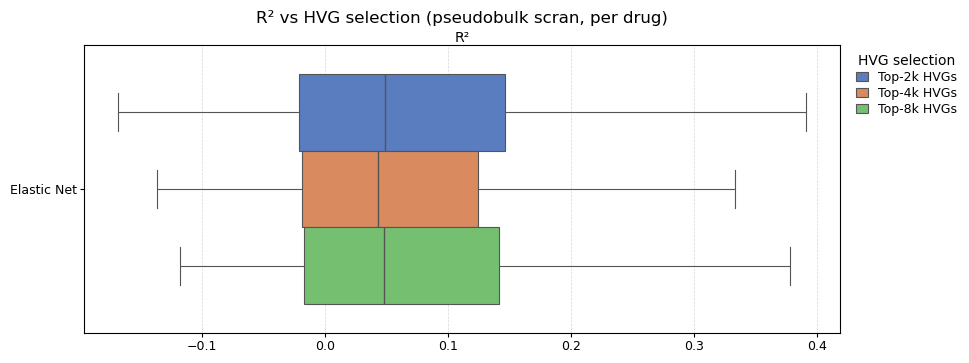

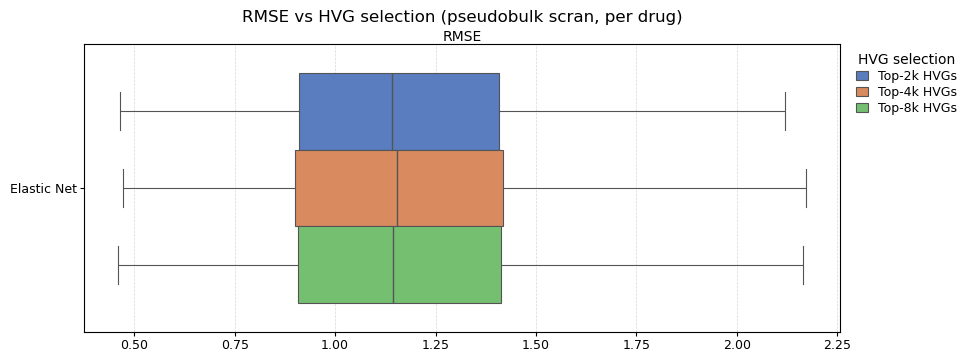

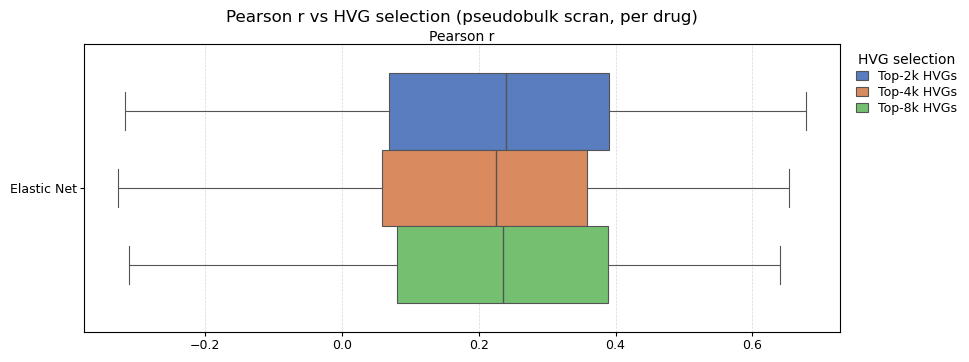

In [4]:
# %% compact boxplot helper (thin lines, legend outside, x-label on top)
def nice_boxplot(df, x_metric, title):
    fig, ax = plt.subplots(figsize=(9, 3.6))
    sns.boxplot(
        data=df, x=x_metric, y="ModelPretty",
        hue="HVGPretty", palette="muted",
        showfliers=False, dodge=True, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel({"r2_mean":"R²", "rmse_mean":"RMSE", "pearson_r":"Pearson r"}.get(x_metric, x_metric),
                  fontsize=10, labelpad=2)
    ax.set_ylabel("")
    ax.legend(title="HVG selection", frameon=False, loc="upper left",
              bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
              handlelength=0.9, borderpad=0.2, labelspacing=0.25)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
    plt.show()

nice_boxplot(df_plot, "r2_mean",  "R² vs HVG selection (pseudobulk scran, per drug)")
nice_boxplot(df_plot, "rmse_mean","RMSE vs HVG selection (pseudobulk scran, per drug)")
if "pearson_r" in df_plot.columns:
    nice_boxplot(df_plot, "pearson_r","Pearson r vs HVG selection (pseudobulk scran, per drug)")


In [5]:
# %% pairwise paired tests among HVG settings (per model) — positive => first is better
def pairwise_tests(df, model, metric, pairs):
    sub = df[df["Model"] == model]
    wide = sub.pivot_table(index="DRUG_ID", columns="HVG", values=metric, aggfunc="mean")
    outs = []
    for a, b in pairs:
        if a not in wide.columns or b not in wide.columns: 
            continue
        pair = wide[[a, b]].dropna()
        if pair.empty: 
            continue
        x, y = pair[a], pair[b]
        d = (x - y) if metric in ("r2_mean","pearson_r") else (y - x)  # positive => first better
        n = len(d)
        outs.append({
            "Model": model, "Metric": metric, "Compare": f"{a} - {b}",
            "ComparePretty": f"{pretty_hvg[a]} - {pretty_hvg[b]}",
            "n": n, "delta_mean": d.mean(), "delta_median": d.median(),
            "win_rate": (d>0).mean(),
            "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n>=5 else np.nan,
            "ttest_p": ttest_rel(x, y, nan_policy="omit").pvalue if n>=5 else np.nan
        })
    return pd.DataFrame(outs) if outs else pd.DataFrame()

pairs = [("hvg2k","hvg4k"), ("hvg8k","hvg4k"), ("hvg8k","hvg2k")]
rows = []
for m in ["ElasticNet","RandomForest"]:
    for met in ["r2_mean","rmse_mean","pearson_r"]:
        if met not in df_all.columns: continue
        out = pairwise_tests(df_all, m, met, pairs)
        if not out.empty: rows.append(out)

pairwise_summary = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()
display(pairwise_summary)


,Model,Metric,Compare,ComparePretty,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,ElasticNet,r2_mean,hvg2k - hvg4k,Top-2k HVGs - Top-4k HVGs,625,0.009308,0.004345,0.5376,0.000585,0.000151
1,ElasticNet,r2_mean,hvg8k - hvg4k,Top-8k HVGs - Top-4k HVGs,625,0.009100,0.007159,0.5632,0.000083,0.000104
2,ElasticNet,r2_mean,hvg8k - hvg2k,Top-8k HVGs - Top-2k HVGs,625,-0.000209,0.000194,0.5008,0.804813,0.928153
3,ElasticNet,rmse_mean,hvg2k - hvg4k,Top-2k HVGs - Top-4k HVGs,625,0.007092,0.002429,0.5376,0.000347,0.000044
4,ElasticNet,rmse_mean,hvg8k - hvg4k,Top-8k HVGs - Top-4k HVGs,625,0.006830,0.003781,0.5632,0.000094,0.000044
5,ElasticNet,rmse_mean,hvg8k - hvg2k,Top-8k HVGs - Top-2k HVGs,625,-0.000262,0.000171,0.5008,0.835111,0.869158
6,ElasticNet,pearson_r,hvg2k - hvg4k,Top-2k HVGs - Top-4k HVGs,625,0.014821,0.013983,0.5616,0.000464,0.002339
7,ElasticNet,pearson_r,hvg8k - hvg4k,Top-8k HVGs - Top-4k HVGs,625,0.016216,0.015766,0.5728,0.000106,0.000825
8,ElasticNet,pearson_r,hvg8k - hvg2k,Top-8k HVGs - Top-2k HVGs,625,0.001395,0.000000,0.4992,0.785510,0.741784


In [6]:
# %% aggregate stats per Model x HVG
def agg_stats(df, metric):
    g = (
        df.groupby(["ModelPretty","HVGPretty"], as_index=False)[metric]
          .agg(mean="mean", std="std", n="count")
    )
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g.rename(columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"})

tables = []
for met in ["r2_mean","rmse_mean","pearson_r"]:
    if met in df_plot.columns:
        tables.append(agg_stats(df_plot, met))
hvg_summary_table = pd.concat(tables, ignore_index=True)
display(hvg_summary_table[["metric","ModelPretty","HVGPretty","N","Mean","Std","95% CI"]].round(4))


,metric,ModelPretty,HVGPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,Top-2k HVGs,625,0.0737,0.1163,0.0091
1,r2_mean,Elastic Net,Top-4k HVGs,625,0.0644,0.1078,0.0085
2,r2_mean,Elastic Net,Top-8k HVGs,625,0.0735,0.1110,0.0087
3,rmse_mean,Elastic Net,Top-2k HVGs,625,1.1838,0.3718,0.0291
4,rmse_mean,Elastic Net,Top-4k HVGs,625,1.1909,0.3755,0.0294
5,rmse_mean,Elastic Net,Top-8k HVGs,625,1.1841,0.3709,0.0291
6,pearson_r,Elastic Net,Top-2k HVGs,625,0.2219,0.2215,0.0174
7,pearson_r,Elastic Net,Top-4k HVGs,625,0.2071,0.2114,0.0166
8,pearson_r,Elastic Net,Top-8k HVGs,625,0.2233,0.2140,0.0168


In [7]:
# %% per-drug winners vs 4k baseline (counts + sign tests), for each model/metric
def wins_vs_baseline(df, model, metric, compare_tag, baseline_tag="hvg4k", tie_tol=0.002):
    sub = df[df["Model"] == model]
    wide = sub.pivot_table(index="DRUG_ID", columns="HVG", values=metric, aggfunc="mean")
    if not ({compare_tag, baseline_tag} <= set(wide.columns)): return None
    pair = wide[[compare_tag, baseline_tag]].dropna()
    if pair.empty: return None
    if metric in ("r2_mean","pearson_r"):
        d = pair[compare_tag] - pair[baseline_tag]     # positive => compare better
    else:
        d = pair[baseline_tag] - pair[compare_tag]     # positive => compare better (lower RMSE)
    winners = np.where(d >  tie_tol, compare_tag,
               np.where(d < -tie_tol, baseline_tag, "Tie"))
    n_non_ties = int((winners != "Tie").sum())
    n_comp = int((winners == compare_tag).sum())
    sign_p = binomtest(n_comp, n_non_ties, 0.5, alternative="two-sided").pvalue if n_non_ties>0 else np.nan
    return pd.DataFrame({
        "Model":[model], "Metric":[metric],
        "Compare":[pretty_hvg[compare_tag]], "Baseline":[pretty_hvg[baseline_tag]],
        "Compare wins":[n_comp],
        "Baseline wins":[int((winners==baseline_tag).sum())],
        "Ties":[int((winners=='Tie').sum())],
        "Compare win rate (no ties)":[n_comp/n_non_ties if n_non_ties else np.nan],
        "Sign test p":[sign_p],
    })

summ_rows = []
for m in ["ElasticNet","RandomForest"]:
    for met, tol in [("r2_mean",0.002), ("rmse_mean",0.005), ("pearson_r",0.01)]:
        if met not in df_all.columns: continue
        for tag in ["hvg2k","hvg8k"]:
            out = wins_vs_baseline(df_all, m, met, compare_tag=tag, tie_tol=tol)
            if out is not None:
                summ_rows.append(out)
wins_vs_4k = pd.concat(summ_rows, ignore_index=True) if summ_rows else pd.DataFrame()
display(wins_vs_4k)


,Model,Metric,Compare,Baseline,Compare wins,Baseline wins,Ties,Compare win rate (no ties),Sign test p
0,ElasticNet,r2_mean,Top-2k HVGs,Top-4k HVGs,326,269,30,0.547899,0.021610
1,ElasticNet,r2_mean,Top-8k HVGs,Top-4k HVGs,344,265,16,0.564860,0.001553
2,ElasticNet,rmse_mean,Top-2k HVGs,Top-4k HVGs,291,237,97,0.551136,0.020993
3,ElasticNet,rmse_mean,Top-8k HVGs,Top-4k HVGs,298,228,99,0.566540,0.002592
4,ElasticNet,pearson_r,Top-2k HVGs,Top-4k HVGs,319,249,57,0.561620,0.003752
5,ElasticNet,pearson_r,Top-8k HVGs,Top-4k HVGs,334,236,55,0.585965,0.000047


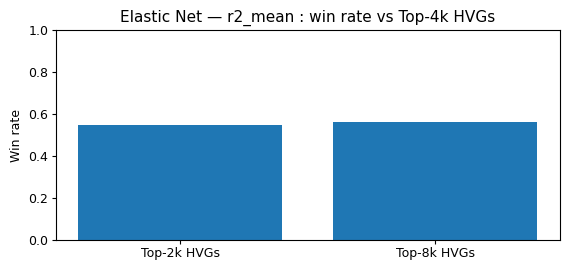

In [8]:
# %% (optional) quick bar of win rates vs 4k for a chosen metric/model
def win_bar_vs_4k(model, metric):
    subset = wins_vs_4k[(wins_vs_4k["Model"]==model) & (wins_vs_4k["Metric"]==metric)]
    if subset.empty: return
    fig, ax = plt.subplots(figsize=(5.8,2.8))
    labels = subset["Compare"].tolist()
    rates = subset["Compare win rate (no ties)"].tolist()
    ax.bar(labels, rates)
    ax.set_ylim(0,1)
    ax.set_title(f"{pretty_model[model]} — {metric} : win rate vs Top-4k HVGs", fontsize=11)
    ax.set_ylabel("Win rate", fontsize=9)
    ax.tick_params(axis="x", labelsize=9)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    plt.tight_layout(); plt.show()

# examples:
win_bar_vs_4k("ElasticNet", "r2_mean")
win_bar_vs_4k("RandomForest", "r2_mean")


/tmp/ipykernel_2062160/1287655623.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


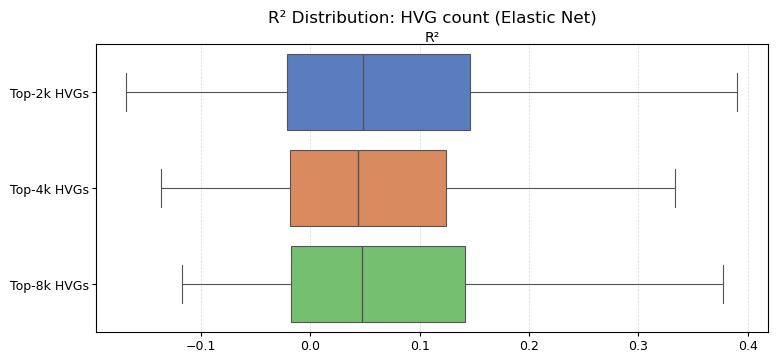

/tmp/ipykernel_2062160/1287655623.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


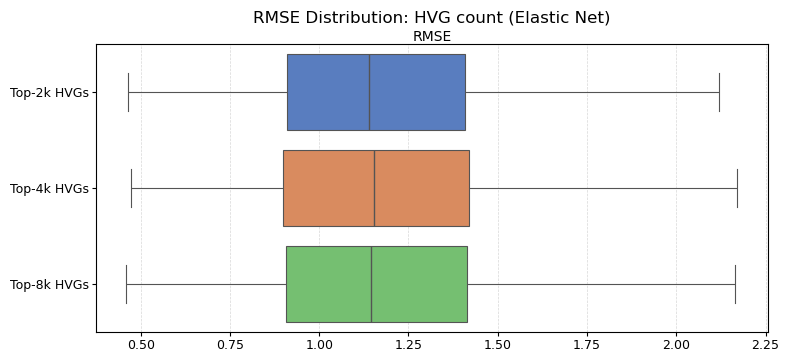

/tmp/ipykernel_2062160/1287655623.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


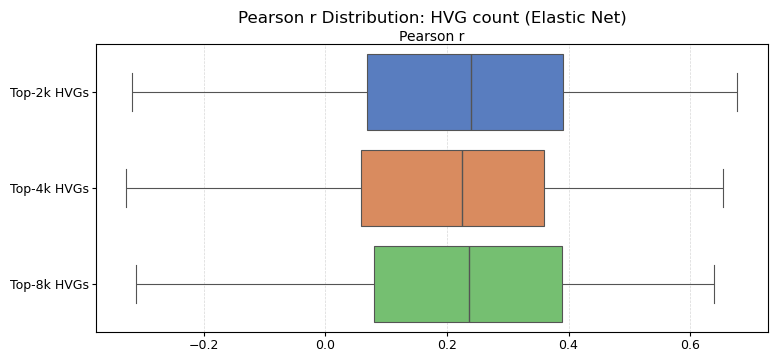

In [11]:
# %% HVG selection — make SEPARATE images (Elastic Net only), no overlay text

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ---- pick the source DF and standardize columns
src = None
for cand in ["df_plot", "df"]:
    if cand in globals() and isinstance(globals()[cand], pd.DataFrame):
        src = globals()[cand].copy()
        break
if src is None:
    raise ValueError("Please define df_plot or df with HVG results.")

# keep Elastic Net only (if Model column exists)
if "Model" in src.columns:
    src = src[src["Model"].isin(["ElasticNet", "Elastic Net"])].copy()

# ensure HVGPretty exists; infer if needed
if "HVGPretty" not in src.columns:
    if "HVG" in src.columns:
        pretty_hvg = {"hvg2k":"Top-2k HVGs","hvg4k":"Top-4k HVGs","hvg8k":"Top-8k HVGs"}
        src["HVGPretty"] = src["HVG"].map(pretty_hvg)
    elif "Dataset" in src.columns:
        def _infer(s):
            s = str(s).lower()
            if "2000" in s or "2k" in s:  return "Top-2k HVGs"
            if "4000" in s or "4k" in s:  return "Top-4k HVGs"
            if "8000" in s or "8k" in s:  return "Top-8k HVGs"
            return s
        src["HVGPretty"] = src["Dataset"].map(_infer)
    else:
        raise ValueError("Need an HVG label column (HVGPretty, HVG, or Dataset).")

order = ["Top-2k HVGs", "Top-4k HVGs", "Top-8k HVGs"]
src["HVGPretty"] = pd.Categorical(src["HVGPretty"], categories=order, ordered=True)

# find Spearman column if present
rho_col = next((c for c in ["spearman_r", "spearman_rho", "spearman"] if c in src.columns), None)

def single_box(x, title, xlabel, outfile):
    fig, ax = plt.subplots(figsize=(8, 3.6))
    sns.boxplot(
        data=src, x=x, y="HVGPretty",
        showfliers=False, dodge=False, palette="muted", ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )
    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(xlabel, fontsize=10, labelpad=2)
    ax.set_ylabel("")
    # no legend (y already encodes HVG choice)
    for sp in ax.spines.values(): sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)
    plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
    if outfile:
        Path(outfile).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(outfile, dpi=200, bbox_inches="tight")
    plt.show()

# --- export three (or four) separate figures, with NO bold overlay text ---
single_box("r2_mean",   "R² Distribution: HVG count (Elastic Net)", "R²",         "Images/hvg_count_r2.png")
single_box("rmse_mean", "RMSE Distribution: HVG count (Elastic Net)", "RMSE",      "Images/hvg_count_rmse.png")
if "pearson_r" in src.columns:
    single_box("pearson_r", "Pearson r Distribution: HVG count (Elastic Net)", "Pearson r", "Images/hvg_count_pearsonr.png")
if rho_col is not None:
    single_box(rho_col, "Spearman ρ Distribution: HVG count (Elastic Net)", "Spearman ρ",  "Images/hvg_count_spearman.png")
